#### 1. Necessary import

In [1]:
import os
from os import listdir
from os.path import isfile, join
from glob import glob

import random
import numpy as np
import pandas as pd
from tqdm import tqdm 

from imgaug import augmenters as iaa
import PIL.Image as Image
import matplotlib.pyplot as plt
# %matplotlib notebook 

# from IPython.core.display import display, HTML
# from IPython.display import display
# display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

#### 2. Loading the Model dataset

In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
lfw_dataset = fetch_lfw_people(min_faces_per_person=70,color=True)
X = lfw_dataset.images
y = lfw_dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
target = lfw_dataset.target
target_names = lfw_dataset.target_names

unique, counts = np.unique(target, return_counts=True)

#### Current data in the table

| Target_names | Number of images per person |
| --- | :-------------:|
| Ariel Sharon | 77 |
| Colin Powell | 236 |
| Donald Rumsfeld | 121 |
| George W Bush | 530 |
| Gerhard Schroeder | 109 |
| Hugo Chavez | 71 |
| Tony Blair | 144 |

In [3]:
from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
y_train = label_as_binary.fit_transform(y_train)
y_test = label_as_binary.fit_transform(y_test)

#### 3. Creating and running Model

In [4]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback
from keras.layers import Input, Dropout, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Conv2D
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

2023-07-18 18:30:41.905208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import cv2

class arc_datagenerator(object):
    def __init__(self, X_train, y_train, X_test, y_test, image_shape=(62, 47)):     
        self.image_shape = image_shape
        
        self.train_images = X_train
        self.ytrain_images = y_train
        self.test_images = X_test
        self.ytest_images = y_test
    
    def get_batch(self, batch_size, is_augmented=False, validation=False):        
        while True:
            if validation:
                image_set_ = self.test_images
                yimage_set_ = self.ytest_images
            else:
                image_set_ = self.train_images
                yimage_set_ = self.ytrain_images
                
            random_indexes = np.random.choice(len(image_set_), batch_size)                   
            batch_images = image_set_[random_indexes]
            batch_labels = yimage_set_[random_indexes]
            
            # preparing images
            prep_images = []
            for image in batch_images:                 
                # image normalization
                image = np.divide(image, 255)
                prep_images.append(image)
            
            batch_images = prep_images
                
            yield [np.array(batch_images), np.array(batch_labels)], np.array(batch_labels)

In [6]:
arc_generator = arc_datagenerator(X_train, y_train, X_test, y_test,)
gen_batch = arc_generator.get_batch(5, is_augmented=False, validation=False)
(batch_img, _), batch_label = next(gen_batch)

In [50]:
##### Displaying images

In [48]:
def show_images(images, title=""):
    fig, ax = plt.subplots(1, len(images), figsize=(15, 15), dpi=100)   
    for i, img in enumerate(images):
        ax[i].imshow(img*255, cmap='summer')
        ax[i].set_title(title)
    [x.axis('off') for x in ax]
    plt.show()

[0 1 0 0 0 0 0] Colin Powell
[0 1 0 0 0 0 0] Colin Powell
[0 0 0 1 0 0 0] George W Bush
[0 1 0 0 0 0 0] Colin Powell
[0 0 0 1 0 0 0] George W Bush


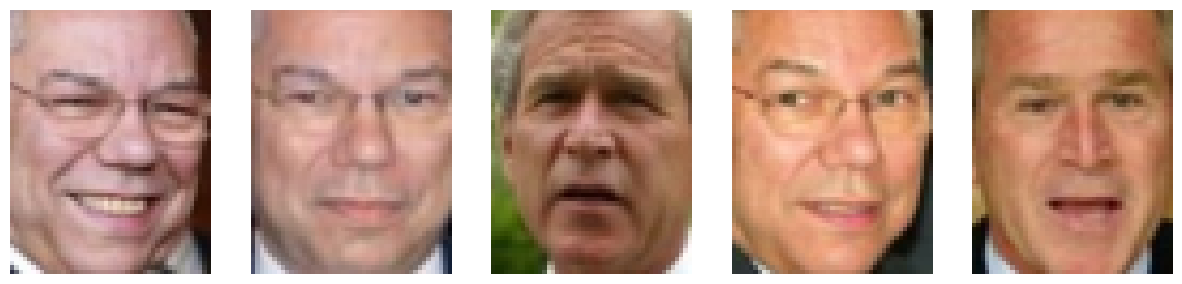

In [49]:
target = lfw_dataset.target
target_names = lfw_dataset.target_names

# visualise generate images
for l in batch_label[:5]:
    print(l, target_names[np.argmax(l)])
    
show_images(batch_img[0][:5])

In [7]:
from metrics import *
import os

In [8]:
# For reference
def create_simple_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_tensor)
    x = AveragePooling2D(pool_size=(3, 3))(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(128, kernel_initializer='he_normal')(x)    
    x = BatchNormalization()(x)
    x = Dense(n_out, activation='softmax')(x)
    
    model = Model(input_tensor, x)
    return model

# Finetune simple model by dropping for the softmax classification head
# s is a scale for logits, setting too low will cause logits to return -1 and u will usual 100% acurracy
# m is a modifier on how much it rely on softmax. setting it to 0 will cause arcface to behave as softmax
def finetune_simple_arcface_model(premodel, n_out):
    output_tensor = Input(shape=n_out)
    
    # remove classification head
    model = Sequential()
    for layer in premodel.layers[:-1]:
        model.add(layer)
    
    # freeze layer, only train layers after flatten
    for layer in model.layers[:-3]:
        layer.trainable = False
    
    # model.add(Dense(128, kernel_initializer='he_normal'))
    output = ArcFace(n_classes=n_out, s=6.0, m=2.0)([model.output, output_tensor])
    
    model = Model([model.input, output_tensor], output)
    return model

# Adding CosFace directly to simple model architecture
def create_simple_arcface_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    output_tensor = Input(shape=n_out)
    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_tensor)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(64, kernel_initializer='he_normal')(x)    
    x = BatchNormalization()(x)
    output = ArcFace(n_classes=n_out, s=6.0, m=2.0)([x, output_tensor])
    
    model = Model([input_tensor, output_tensor], output)
    return model

In [9]:
batch_size = 40

model_path = os.path.join("weights", "arcface_weights.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

In [12]:
train_gen = arc_generator.get_batch(batch_size, is_augmented=True, validation=False)
test_gen = arc_generator.get_batch(258, is_augmented=False, validation=True)

In [13]:
simple_model = create_simple_model((62,47,3), 7)

2023-07-18 18:32:08.945468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-18 18:32:08.951407: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

#X_train, y_train = next(train_gen)
# simple_arcface_model = create_simple_arcface_model((224,224, 3), 4)

simple_arcface_model = finetune_simple_arcface_model(simple_model, 7)
simple_arcface_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'], run_eagerly=True)
simple_arcface_model.summary()  

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 62, 47, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 60, 45, 32)   896         ['input_1[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 20, 15, 32)  0           ['conv2d[1][0]']                 
 ing2D)                                                                                           
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 15, 32)  128         ['average_pooling2d[1][0]']

In [15]:
history = simple_arcface_model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=next(test_gen),
    epochs=10,
    verbose=1, 
    # callbacks=[reduceLROnPlato, checkPoint, earlyStop]
) 

Epoch 1/10


2023-07-18 18:32:13.633329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 2s 78ms/step - loss: 2.4748 - accuracy: 0.5080 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 2s 74ms/step - loss: 0.0415 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 2s 75ms/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 2s 79ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 2s 76ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 2s 75ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 2s 76ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 8/10
25/25 [======

#### 4. Evaluation

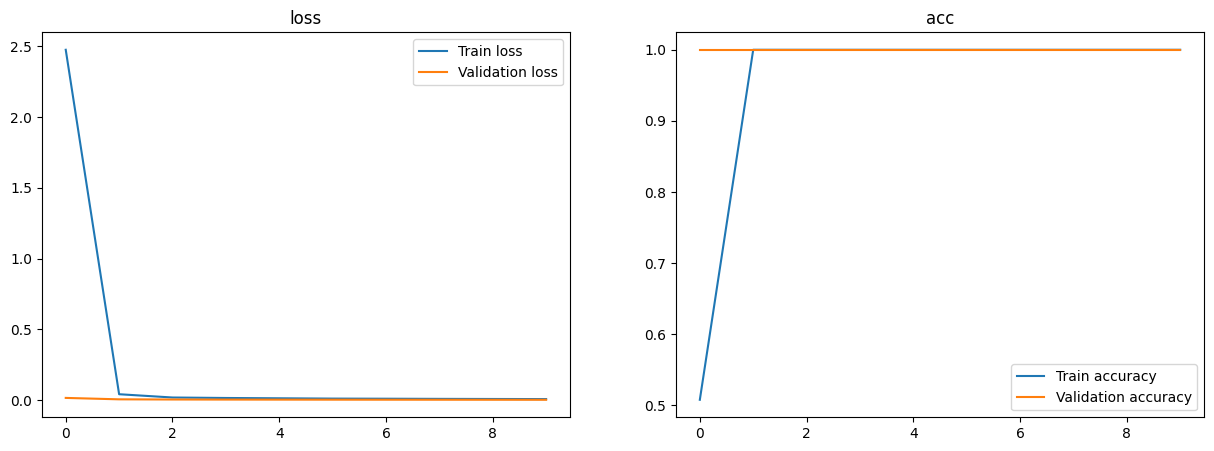

In [16]:
# Draw learning curve
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()
    
show_history(history)

In [17]:
X_test.shape

(258, 62, 47, 3)

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

test_gen = arc_generator.get_batch(258, is_augmented=False, validation=True)
batch_img, batch_label = next(test_gen)

predict_idxs = simple_arcface_model.predict(batch_img)
predict_idxs = np.argmax(predict_idxs, axis=1)

cm = confusion_matrix(np.argmax(batch_label, axis=1), predict_idxs)
print(cm)

9/9 [==============================] - 0s 13ms/step
[[  6   0   0   0   0   0   0]
 [  0  63   0   0   0   0   0]
 [  0   0  20   0   0   0   0]
 [  0   0   0 117   0   0   0]
 [  0   0   0   0  18   0   0]
 [  0   0   0   0   0  15   0]
 [  0   0   0   0   0   0  19]]


In [19]:
target = lfw_dataset.target
target_names = lfw_dataset.target_names


print(classification_report(np.argmax(batch_label, axis=1), predict_idxs, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      1.00      1.00         6
     Colin Powell       1.00      1.00      1.00        63
  Donald Rumsfeld       1.00      1.00      1.00        20
    George W Bush       1.00      1.00      1.00       117
Gerhard Schroeder       1.00      1.00      1.00        18
      Hugo Chavez       1.00      1.00      1.00        15
       Tony Blair       1.00      1.00      1.00        19

         accuracy                           1.00       258
        macro avg       1.00      1.00      1.00       258
     weighted avg       1.00      1.00      1.00       258

